# Performing cross validation and elastic net
To perform cross validation and elastic net.

Will use the ML input data created earlier (fullRegression_pipeline) script

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [73]:
# Reading the input data
df = pd.read_csv("./datasets/carPrice_ML_input.csv")
print(df.head())

   wheelbase  carlength  carwidth  carheight  curbweight  cylindernumber  \
0  -0.467957  -0.075893  0.137662  -1.422740    0.437186       -0.378757   
1   1.142419   1.460213  2.404199   0.813384    0.497860        0.472149   
2   2.150938   1.972248  2.670851   0.691414    2.099292        3.024870   
3   0.264032   0.475530  0.404313   0.569443    0.161394        0.472149   
4  -1.980735  -2.328848 -0.928944  -1.178799   -1.386717       -0.378757   

   enginesize  boreratio    stroke  compressionratio  ...  highwaympg  \
0    0.599512   1.035256  2.092340         -0.796711  ...   -0.942169   
1    0.152298  -0.487952  0.411746         -0.428383  ...   -0.803091   
2    3.908897   1.778284  0.243686         -0.551159  ...   -2.054793   
3    0.152298  -0.487952  0.411746         -0.428383  ...   -0.942169   
4   -0.831573  -1.528191  0.445357         -0.256497  ...    1.004924   

   fueltype  aspiration  doornumber  carbody  drivewheel  enginelocation  \
0       1.0         1.0     

In [74]:
# train test split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Ridge regression CV

Using ridge regression CV

Choosing k=5 (5-fold cross validation)

Plan: use a range of alpha values : 0.1 to 15 (stepsize = 0.5) ->> choose best alpha with minimal error ->> rerun on entire data

In [75]:
X = df.drop("price", axis = 1)
y = df["price"]
xtrain,xtest,ytrain,ytest = train_test_split(X,y, test_size = 0.25, random_state = 1987)

In [ ]:
print(xtrain.shape, xtest.shape)

In [76]:

alpha_vals = np.arange(0.1,15, 0.5)
regressor = RidgeCV(cv = 5, alphas = alpha_vals)
regressor.fit(xtrain,ytrain)
#predict on test data
ypred_ridge = regressor.predict(xtest)


In [77]:
r2score = r2_score(ytest, ypred_ridge)
adjr2 = 1 - ((1-r2score) * len(ytest) - 1) / (len(ytest) - xtest.shape[1] - 1 )
# print(r2score)
# print(adjr2)
mse = mean_squared_error(ytest,ypred_ridge)
mae = mean_absolute_error(ytest,ypred_ridge)
rmse = np.sqrt(mse)
r2 = r2_score(ytest, ypred_ridge)
print(f"For 5-fold CV ridge regression with all vars:\nMean squared error: {mse}\nMean absolute error: {mae}\nR2: {r2score}\nAdjusted R2: {adjr2}")

For 5-fold CV ridge regression with all vars:
Mean squared error: 13354143.900840145
Mean absolute error: 2449.7374877965626
R2: 0.7982507499210919
Adjusted R2: 0.6727254826171303


From 0.6051, R2 improved to 0.6727. Get alpha value and use on un-correlated features

In [78]:
print(regressor.alpha_)

14.6


In [80]:
#getting feature correlations
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
def calculate_VIF(df):
  df["intercept"] = 1
  vif_data = pd.DataFrame()
  vif_data["variables"] = df.columns
  vif_data['VIF'] = [VIF(df.values, i) for i in range(df.shape[1])]
  return vif_data


vif_vals = calculate_VIF(xtrain.iloc[:,:-1])
print(vif_vals)

uncollinear_vars2 = vif_vals[vif_vals["VIF"] < 10]["variables"].values 
# print(type(uncollinear_vars))
# uncollinear_vars = list(uncollinear_vars).append("price")
# uncollinear_vars = np.append(uncollinear_vars, "price")
print(uncollinear_vars2)


           variables         VIF
0          wheelbase   11.867639
1          carlength   16.843669
2           carwidth    8.696783
3          carheight    3.271499
4         curbweight   18.638413
5     cylindernumber   14.021119
6         enginesize   34.526986
7          boreratio    4.601161
8             stroke    2.141950
9   compressionratio   88.633210
10        horsepower   14.782796
11           peakrpm    2.922956
12           citympg   31.138620
13        highwaympg   28.794630
14          fueltype   98.431102
15        aspiration    3.586612
16        doornumber    2.618777
17           carbody    3.577163
18        drivewheel    2.816256
19    enginelocation    2.203576
20        enginetype    1.442202
21         intercept  920.392522
['carwidth' 'carheight' 'boreratio' 'stroke' 'peakrpm' 'aspiration'
 'doornumber' 'carbody' 'drivewheel' 'enginelocation' 'enginetype']


20      1.442202
8       2.141950
19      2.203576
16      2.618777
18      2.816256
11      2.922956
3       3.271499
17      3.577163
15      3.586612
7       4.601161
2       8.696783
0      11.867639
5      14.021119
10     14.782796
1      16.843669
4      18.638413
13     28.794630
12     31.138620
6      34.526986
9      88.633210
14     98.431102
21    920.392522
Name: VIF, dtype: float64


<Axes: ylabel='VIF'>

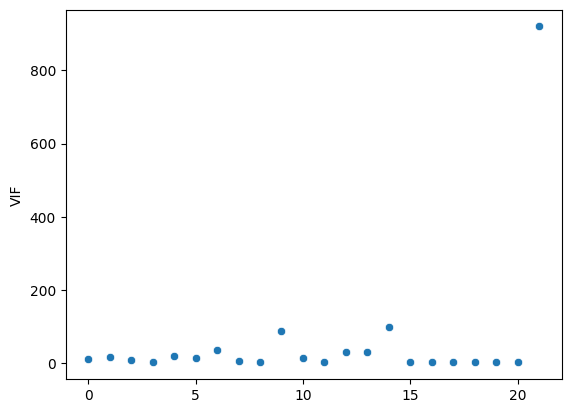

In [81]:
sorted_vif = vif_vals["VIF"].sort_values()
print(sorted_vif)
sns.scatterplot(sorted_vif)

In [ ]:
# viewing correlation in pairplot
sns.pairplot(xtrain)

<Axes: >

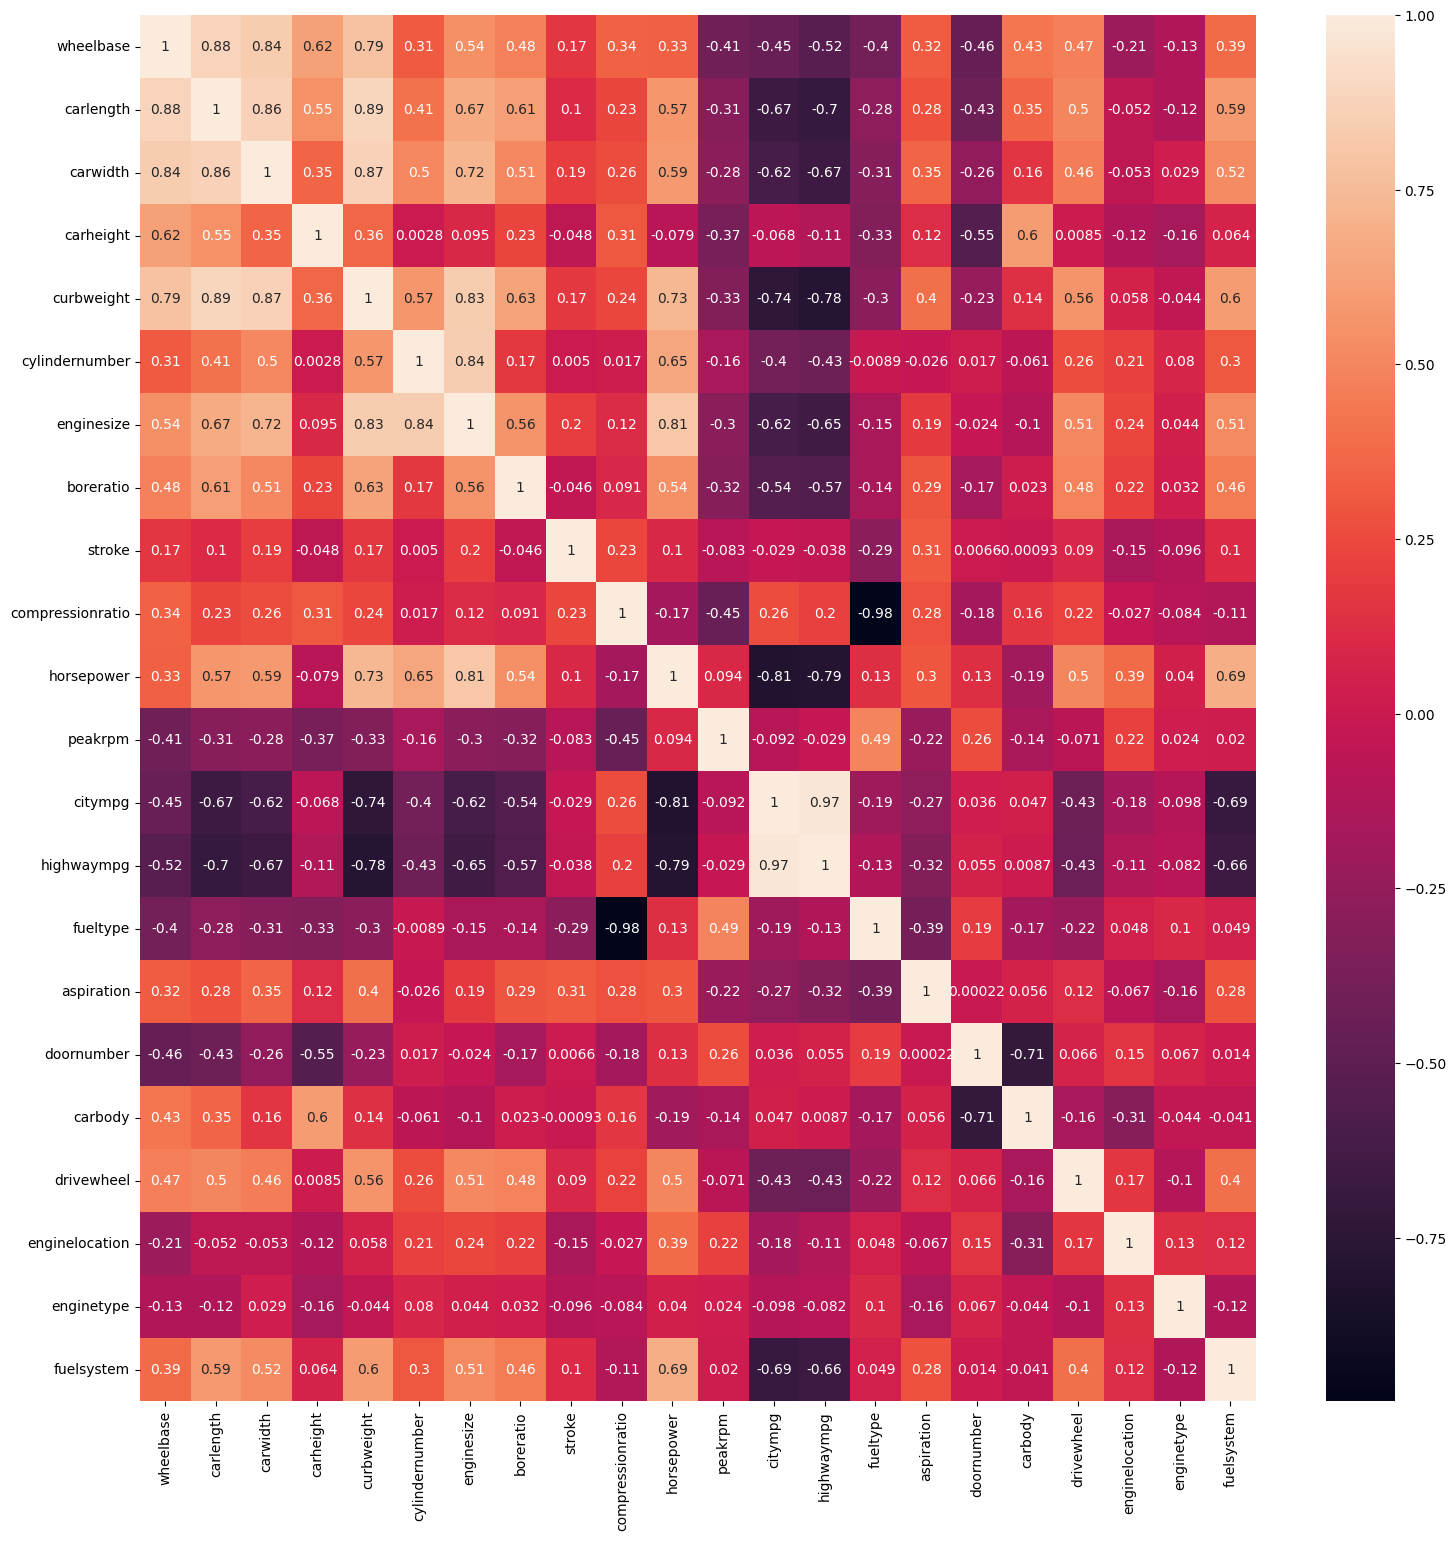

In [82]:
plt.figure(figsize=(18,18))
corr_vals = xtrain.corr()
sns.heatmap(corr_vals, annot =  True)

In [83]:
# getting correlated variables
def get_corr(data, cutoff = 0.9):
  corr_var_names = []
  n_row, n_col = data.shape[0], data.shape[1]
  print(n_row, n_col)
  for i in range(n_row):
    for j in range(n_col):
      if i != j:
        if abs(data.iloc[i,j]) > cutoff:
          var1 = data.columns[i]
          var2 = data.index[j]
          corr_cols = "-".join([var1, var2])
          corr_var_names.append(corr_cols)
  return corr_var_names
  
  
corr_vars = get_corr(corr_vals)
print(corr_vars)

22 22
['compressionratio-fueltype', 'citympg-highwaympg', 'highwaympg-citympg', 'fueltype-compressionratio']


From 22 features, 11 features are identified as collinear (high correlation). Removing them

In [84]:
# removing collinear variables identified using VIF
xtrain_non_collinear = xtrain.drop(columns = [i for i in xtrain.columns if i not in uncollinear_vars2])
xtest_non_collinear = xtest.drop(columns = [i for i in xtrain.columns if i not in uncollinear_vars2])

In [85]:
# redo ridge regression with CV
alpha_vals = np.arange(0.1,15, 0.5)
regressor = RidgeCV(cv = 5, alphas = alpha_vals)
regressor.fit(xtrain_non_collinear,ytrain)
#predict on test data
ypred_ridge_cv = regressor.predict(xtest_non_collinear)


In [86]:
r2score = r2_score(ytest, ypred_ridge_cv)
adjr2 = 1 - ((1-r2score) * len(ytest) - 1) / (len(ytest) - xtest.shape[1] - 1 )
# print(r2score)
# print(adjr2)
mse = mean_squared_error(ytest,ypred_ridge_cv)
mae = mean_absolute_error(ytest,ypred_ridge_cv)
rmse = np.sqrt(mse)
r2 = r2_score(ytest, ypred_ridge_cv)
print(f"For 5-fold CV ridge regression with all vars:\nMean squared error: {mse}\nMean absolute error: {mae}\nR2: {r2score}\nAdjusted R2: {adjr2}")

For 5-fold CV ridge regression with all vars:
Mean squared error: 22923368.208763156
Mean absolute error: 2998.278686684791
R2: 0.6536826037115196
Adjusted R2: 0.4134998411378973


In [87]:
print(regressor.alpha_)

0.1


Clearly, removing collinear variables lead to poor fit.

VIF should be <10 by convention

## LassoCV
using Lasso CV as it can perform feature selection

In [88]:
regressor = LassoCV(cv = 5, n_jobs = -1)
# print(xtrain.head())
regressor.fit(xtrain,ytrain)
#predict on test data
ypred_lasso_cv = regressor.predict(xtest)

In [89]:
r2score = r2_score(ytest, ypred_lasso_cv)
adjr2 = 1 - ((1-r2score) * len(ytest) - 1) / (len(ytest) - xtest.shape[1] - 1 )
# print(r2score)
# print(adjr2)
mse = mean_squared_error(ytest,ypred_lasso_cv)
mae = mean_absolute_error(ytest,ypred_lasso_cv)
rmse = np.sqrt(mse)
r2 = r2_score(ytest, ypred_lasso_cv)
print(f"For 5-fold CV lasso regression with all vars:\nMean squared error: {mse}\nMean absolute error: {mae}\nR2: {r2score}\nAdjusted R2: {adjr2}")

For 5-fold CV lasso regression with all vars:
Mean squared error: 12598839.907415576
Mean absolute error: 2340.5975278060887
R2: 0.8096615910342706
Adjusted R2: 0.693186301164899


So far the best fit is obtained with lasso cv with adjusted R2 = 0.6932 (~10% increase from 0.593 when using linear regression)

In [90]:
print("Mean MSE for each alpha:", regressor.mse_path_.mean(axis=1))
print(regressor.alphas_)

Mean MSE for each alpha: [64777622.92393671 63338261.41284063 61244742.74475928 59294958.98967846
 57565468.77463331 55422852.82227837 53169094.79233249 51136971.06959913
 47704713.75412763 43970830.03573664 40542832.20371614 37385951.68937136
 34669070.34819079 32225700.64614465 30093904.54851687 28236945.7077744
 26619664.46272459 25170978.05586649 23890538.71583781 22729214.25692925
 21607383.22034381 20605122.24910158 19688949.95336867 18863554.02630864
 18147911.40069967 17527833.84866095 16994422.90940108 16545005.82909041
 16170024.3643173  15852140.06436568 15575800.01759065 15335545.94983753
 15139816.46254471 14970919.46986281 14829505.09795867 14720786.95038948
 14634145.2165377  14568971.78932595 14512334.07307633 14452263.71271906
 14371557.91417677 14245167.35083808 14090769.89106955 13946058.83966055
 13784945.29407165 13612262.55582235 13458768.47993207 13322406.22532179
 13211031.40346519 13088762.47738717 12984140.33285169 12900339.6919219
 12833609.59415049 12793163.

Text(0, 0.5, 'Mean MSE')

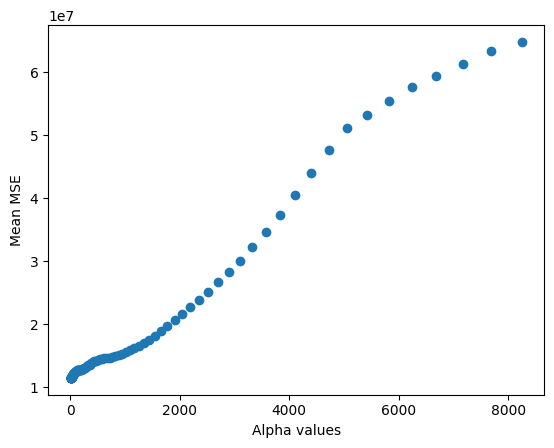

In [91]:
plt.scatter(x=regressor.alphas_, y=regressor.mse_path_.mean(axis=1))
plt.xlabel("Alpha values")
plt.ylabel("Mean MSE")

In [92]:
print(regressor.alpha_)
best_alpha = regressor.alpha_

14.403019515172613


In [93]:
# redo lasso with the best alpha
from sklearn.linear_model import Lasso
regress1_lasso = Lasso(alpha = best_alpha, random_state = 1987)
regress1_lasso.fit(xtrain, ytrain)
ypred_all_lasso = regress1_lasso.predict(xtest)

In [94]:
r2score = r2_score(ytest, ypred_all_lasso)
adjr2 = 1 - ((1-r2score) * len(ytest) - 1) / (len(ytest) - xtest.shape[1] - 1 )
# print(r2score)
# print(adjr2)
mse = mean_squared_error(ytest,ypred_all_lasso)
mae = mean_absolute_error(ytest,ypred_all_lasso)
rmse = np.sqrt(mse)
r2 = r2_score(ytest, ypred_all_lasso)
print(f"For lasso regression with best alpha and all vars:\nMean squared error: {mse}\nMean absolute error: {mae}\nR2: {r2score}\nAdjusted R2: {adjr2}")

For lasso regression with best alpha and all vars:
Mean squared error: 12598839.907415576
Mean absolute error: 2340.5975278060887
R2: 0.8096615910342706
Adjusted R2: 0.693186301164899


The adjusted R2 of best model using ridge and lasso so far is 0.6932

## Elastic Net
Using elastic net regression

In [113]:
alphas = np.arange(0.5,5,0.25)
l1_ratios = np.arange(0.5,0.95,0.025)

In [114]:

def runEN(xtrain,ytrain,alphaval, l1_frac):
  regressor = ElasticNet(alpha = alphaval, l1_ratio=l1_frac)
  regressor.fit(xtrain,ytrain)
  ypred_en = regressor.predict(xtest)
  return regressor, ypred_en

def get_metrics(regression, ytest, ypred):
  r2score = r2_score(ytest, ypred)
  adjr2 = 1 - ((1-r2score) * len(ytest) - 1) / (len(ytest) - xtest.shape[1] - 1 )
# print(r2score)
# print(adjr2)
  mse = mean_squared_error(ytest,ypred)
  mae = mean_absolute_error(ytest,ypred)
  rmse = np.sqrt(mse)
  
  return mse,mae,rmse,r2score,adjr2
  

In [123]:
metrics_df = pd.DataFrame(columns = ["alpha", "l1_ratio", "mse", "adjr2"])
alpha_df = []
l1_df = []
mse_vals = []
adjr2_vals = []   

In [124]:
for alpha_value in alphas:
  for l1_r in l1_ratios:
    alpha_df.append(alpha_value)
    l1_df.append(l1_r)
    regressor,ypred_loop = runEN(xtrain=xtrain, ytrain=ytrain, alphaval = alpha_value, l1_frac = l1_r)
    mse,mae,rmse,r2score,adjr2 = get_metrics(regression=regressor, ytest=ytest, ypred=ypred_loop)
    mse_vals.append(mse)
    adjr2_vals.append(adjr2)
    


In [125]:
metrics_df["mse"] = mse_vals
metrics_df["alpha"] = alpha_df
metrics_df["l1_ratio"] = l1_df
metrics_df["adjr2"] = adjr2_vals
print(metrics_df.head())

   alpha  l1_ratio           mse     adjr2
0    0.5     0.500  1.318974e+07  0.677179
1    0.5     0.525  1.318470e+07  0.677316
2    0.5     0.550  1.318204e+07  0.677388
3    0.5     0.575  1.318194e+07  0.677390
4    0.5     0.600  1.318465e+07  0.677317


In [134]:
print(max(metrics_df["adjr2"]))
print(min(metrics_df["mse"]))
c1 = metrics_df["adjr2"] >= max(metrics_df["adjr2"])
c2 = metrics_df["adjr2"] <= min(metrics_df["mse"])
print(metrics_df[ c1 & c2 ])

0.67759084673919
13174540.67811096
     alpha  l1_ratio           mse     adjr2
197    3.0     0.925  1.317454e+07  0.677591


It appears that alpha of 3 and l1_ratio of 0.925 provides the least mse and max adj r2